# Plot Argo floats in Tropical Pacific used in ECCOv4r4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

### Read in the dataset

Do some renaming of the variables

In [2]:
def read_and_rename(fname, **kwargs):
    """ Read in a dataset, rename variables, and restrict to our location
    """
    xds = xr.open_dataset(fname, **kwargs)
    
    # remove the 'prof_' prefix
    for vname in xds.data_vars:
        xds = xds.rename({vname:vname.replace('prof_','')})
        
    # rename the "iPROF" dimension with profile
    xds = xds.rename_dims({'iPROF':'profile'})
    
    # swap the "iDEPTH" dimension with actual depth
    xds = xds.swap_dims({'iDEPTH':'depth'})
        
    # restrict to our lon/lat box
    xds = xds.where( (xds.lon>140) | (xds.lon<-80), drop=True)
    xds = xds.where( (xds.lat<15) & (xds.lat>-15), drop=True)
    return xds

In [3]:
#ds1 = read_and_rename('/scratch2/shared/ecco/v4r4/profiles/ARGO_20190131_95to13_model.nc',
#                      chunks={'iPROF':10_000})
ds2 = read_and_rename('/scratch2/shared/ecco/v4r4/profiles/ARGO_20190131_14to17_model.nc',
                      chunks={'iPROF':50_000})

## Convert the time units to something we can use

And swap the `profile` dimension for this `time`, which is more intuitive and useful

In [4]:
def convert_time(xds):
    """ Convert the strange time units provided into something useful
    """
    
    # get year month day as array of 8 character string
    ymd = xds['YYYYMMDD'].astype(int).astype(str).values
    
    # Get hours, minutes, seconds as strings, padded with 0's in the front
    # if there are less than 6 characters
    hms = xds.HHMMSS.astype(int).astype(str).values
    hms = [f'{x:>06s}' for x in hms]
    
    # Now stick it together in a format that numpy.datetime64 recognizes
    # then return it as an xarray dataarray
    time = [f'{x[:4]}-{x[4:6]}-{x[6:]}T{y[:2]}:{y[2:4]}:{y[4:]}' for x,y in zip(ymd,hms)]
    time = [np.datetime64(x) for x in time]
    time = xr.DataArray(time,coords=xds['YYYYMMDD'].coords,dims=xds['HHMMSS'].dims)
    return time

In [5]:
#ds1['time'] = convert_time(ds1)
ds2['time'] = convert_time(ds2)

Swap out the dims

In [6]:
#ds1 = ds1.swap_dims({'profile':'time'}).sortby('time')
ds2 = ds2.swap_dims({'profile':'time'}).sortby('time')

## Restrict to time period that we want

Which is 1997-1998 and 2014-2016, I'll make two separate datasets but at this stage we could merge the two
datasets together now that they have an axis (time) which it makes sense to concatenate them together along.
e.g. with
```python
ds = xr.concat([ds1,ds2],dim='time')
```

Note that `slice` is not inclusive, so `slice(1,3)` has everything starting at 1 and up to but not including 3.

In [7]:
#ds1 = ds1.sel(time=slice('1997','1999-01-01'))
ds2 = ds2.sel(time=slice('2014','2017-01-01'))

In [8]:
#len(ds1.time)

There are no Argo floats during the first period, so we can skip this one.

### Make a plot of locations

In [10]:
%%time
ds2.lon.load();

CPU times: user 152 ms, sys: 28.2 ms, total: 180 ms
Wall time: 71.9 ms


<xarray.DataArray 'lon' (time: 62528)>
array([ 149.603,  169.843,  -99.028, ...,  160.452,  175.343, -102.945])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T00:00:31 ... 2017-01-01T22:54:20
Attributes:
    long_name:  Longitude (degree East)
    units:

In [11]:
%%time
ds2.lat.load();

CPU times: user 129 ms, sys: 27.4 ms, total: 157 ms
Wall time: 60.1 ms


<xarray.DataArray 'lat' (time: 62528)>
array([ 11.864,   7.689,   0.134, ...,   9.988,  13.593, -14.02 ])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T00:00:31 ... 2017-01-01T22:54:20
Attributes:
    long_name:  Latitude (degree North)
    units:

### Run through lon/lat pairs and get the unique ones. Additionally, round to nearest 10th of degree longitude/latitude

This still leaves ~40k points, which is a plotting nightmare.

In [21]:
def get_unique_tuples(mylist):
    
    from collections import Counter
    
    # Create a list of sets indicating how many times this pair shows up
    the_count = Counter(frozenset(x) for x in mylist)
    
    # return the unique ones
    return [x for x in mylist if the_count[frozenset(x)]==1]

In [27]:
locations = [(np.round(lo,decimals=1),np.round(la,decimals=1)) for lo,la in zip(ds2.lon.values,ds2.lat.values)]
unique_locs = get_unique_tuples(locations)

CPU times: user 7min 22s, sys: 4.11 s, total: 7min 26s
Wall time: 7min 26s


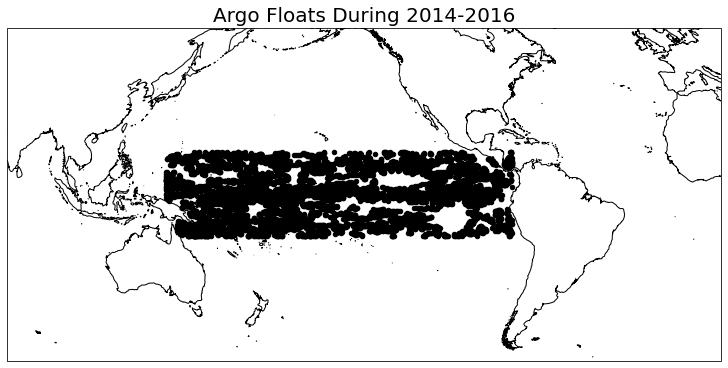

In [33]:
%%time
nrows = 1
fig,ax = plt.subplots(nrows,1,figsize=(12,5*nrows),
                      subplot_kw={'projection':ccrs.Robinson(-140)},
                      constrained_layout=True)

label = '2014-2016'
for lon,lat in unique_locs[:10_000]:
    ax.scatter(lon,lat,marker='o',s=20,transform=ccrs.PlateCarree(),color='black')
    
ax.set_extent([100,-50,-60,60],crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.set_title(f'Argo Floats During {label}',fontsize=20)
    
fig.savefig('figures/eccov4r4_euc_argo.png',dpi=300,bbox_inches='tight')